<a href="https://colab.research.google.com/github/tsangrebecca/PersonalProjects/blob/main/Yelp_reviews_analysis_with_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Analyzing Yelp reviews with NLP and SpaCy

In [ ]:
import spacy
spacy.util.fix_random_seed(0)

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV

import gensim
import gensim.corpora as corpora
from gensim.models.ldamodel import LdaModel

import re


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
import warnings

# Filter out deprecation warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
# Load reviews from URL
data_url = 'https://raw.githubusercontent.com/bloominstituteoftechnology/data-science-practice-datasets/main/unit_4/unit1_nlp/review_sample.json'

# Import the data into a DataFrame named df
df = pd.read_json(data_url, lines=True)

In [ ]:
df.head()

,business_id,cool,date,funny,review_id,stars,text,useful,user_id
0,nDuEqIyRc8YKS1q1fX0CZg,1,2015-03-31 16:50:30,0,eZs2tpEJtXPwawvHnHZIgQ,1,"BEWARE!!! FAKE, FAKE, FAKE....We also own a sm...",10,n1LM36qNg4rqGXIcvVXv8w
1,eMYeEapscbKNqUDCx705hg,0,2015-12-16 05:31:03,0,DoQDWJsNbU0KL1O29l_Xug,4,Came here for lunch Togo. Service was quick. S...,0,5CgjjDAic2-FAvCtiHpytA
2,6Q7-wkCPc1KF75jZLOTcMw,1,2010-06-20 19:14:48,1,DDOdGU7zh56yQHmUnL1idQ,3,I've been to Vegas dozens of times and had nev...,2,BdV-cf3LScmb8kZ7iiBcMA
3,k3zrItO4l9hwfLRwHBDc9w,3,2010-07-13 00:33:45,4,LfTMUWnfGFMOfOIyJcwLVA,1,We went here on a night where they closed off ...,5,cZZnBqh4gAEy4CdNvJailQ
4,6hpfRwGlOzbNv7k5eP9rsQ,1,2018-06-30 02:30:01,0,zJSUdI7bJ8PNJAg4lnl_Gg,4,"3.5 to 4 stars\n\nNot bad for the price, $12.9...",5,n9QO4ClYAS7h9fpQwa5bhA


In [ ]:
df.shape

(10000, 9)

In [ ]:
df.shape

(10000, 9)

## Tokenize Function

In [ ]:
# Use small to load faster
nlp = spacy.load('en_core_web_sm')

In [ ]:
def tokenize(doc):

  lemmas = []
  for token in nlp(doc):
    if (not token.is_stop) and (not token.is_punct) and (not token.is_space):
      lemmas.append(token.lemma_.lower())
  return lemmas

## Vector Representation

In [ ]:
%%time

tfidf = TfidfVectorizer(stop_words='english', max_features=1000)
dtm = tfidf.fit_transform(df.text)
dtm = pd.DataFrame(dtm.todense(), columns=tfidf.get_feature_names_out())
print(dtm.shape)
dtm.head()


(10000, 1000)
CPU times: user 934 ms, sys: 85.3 ms, total: 1.02 s
Wall time: 1.02 s


,00,10,100,11,12,15,20,24,25,30,...,wow,write,wrong,year,years,yelp,yes,young,yum,yummy
0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.169834,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
1,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
2,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.153861,0.138843,0.0,...,0.0,0.0,0.0,0.118308,0.0,0.0,0.0,0.149121,0.0,0.0
3,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
4,0.0,0.0,0.0,0.0,0.172619,0.154652,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0


In [ ]:
# Create and fit a NearestNeighbors model named "nn"
nn = NearestNeighbors(n_neighbors=10, algorithm='auto')
nn.fit(dtm)

NearestNeighbors(n_neighbors=10)

For fun, create a fake review and query 10 most similar reviews to it.

In [ ]:
# Create a fake review and find the 10 most similar reviews
fake_review = "Can't keep count of how many times I've been here now. Their avocado smoothie is consistently to die for. That's a huge opportunity cost for me to try anything else lol. Maybe the mung bean one is a close second. One time I'd try their durian but let me just enjoy my avocado smoothie a few more times first. Boba texture, amount and flavor was one of the best. Price is unbelievable. That's why it's always crowded! Bring cash unless you wanna use some unknown random ATM at their store."

fake_review_vector = tfidf.transform([fake_review]).toarray()
neigh_dist, neigh_index = nn.kneighbors(fake_review_vector)

count = 0
for most_similar_review_index in neigh_index[0]:
  most_similar_review = df.text.iloc[most_similar_review_index]
  count += 1
  print("\n", count, " ", most_similar_review)


 1   旅行でラスベガスに来ましたがネイルがはげてるのが気になり、探したお店でした。
質問にも丁寧に答えてくれましたし、日本人の方も日本語が話せる方も居て、とても綺麗で居心地のいいお店でした。 
ネイルはちはるさんと言う綺麗な方が丁寧にしてくれとても気に入りました。
予定になかったまつ毛エクステもお願いし、日本ではまだあまりないブラウンカラーのエクステをしてもらい、とても気に入りました。
また是非マッサージなどで伺いたいと思います。

 2   天氣很熱吃不下東西，今天我點了一個韓國冷面湯、餐後點了甜點，冰沙系列不會太甜膩，覺得店家很用心製作，包含擺盤精緻、佐料衛生，夏日想開胃，這是一個不錯的選擇，服務人員也很敬業，以後會常常來

 3   Solid place. I live nearby so it's a good place to drop in when I don't feel like cooking. Everything I've tried is very flavourful. The Arepa Reina (chicken/avocado arepa) is really tasty but the mayo to avocado ratio is wayy off, too much mayo and not enough avocado. The beef empanada is a good size and very very tasty. Portions are decent for the price too.

 4   We loved everything except for 1 thing..
AMAZING kalbi ribs, rock & roll, aria, coco shrimp, avocado bomb. Order it all!
Didn't like the red rock. Weird consistency and lacked something. Just doesn't work. 

Also our avocado bomb barely had avocado unlike the previous pics posted.  We were kinda bummed 

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


In [ ]:
print(neigh_index)

[[6204 6311 4126 7910 7575 7081 3416  874 1816 3431]]


## Predict the stars of the reviews in this dataset

In [ ]:
# Set up train and test data
from sklearn.model_selection import train_test_split
target = 'stars'
y = df[target]
X = df['text']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Build Pipeline
vect = TfidfVectorizer(stop_words='english')
clf = KNeighborsClassifier()
pipe = Pipeline([('vect', vect), ('clf', clf)])

# Parameter dict, one parameter with 2 values for the vectorizer, one parameter with 2 values for model, use n_jobs=1
parameters = {
    'vect__ngram_range': ((1,1), (1,2)),
    'clf__n_neighbors' : (4, 5)
}
# Gridsearch as gs
gs = GridSearchCV(pipe, parameters, cv=3, n_jobs=1, verbose=1)
gs.fit(X_train, y_train)
gs.best_score_
print(gs.best_params_)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
{'clf__n_neighbors': 5, 'vect__ngram_range': (1, 2)}


In [ ]:
# Predict the ratings for the test set using the best model
best_model = gs.best_estimator_
y_pred = best_model.predict(X_test)

In [ ]:
# Predict the score for my review
predicted_score = best_model.predict([fake_review])
print(f'Predicted Score: {predicted_score[0]}')

Predicted Score: 2


## LDA Topic Modeling

In [ ]:
# Do not change this value
num_topics = 5

In [ ]:
df['lemmas'] = df['text'].apply(tokenize)

In [ ]:
id2word = corpora.Dictionary(df['lemmas'])
corpus = [id2word.doc2bow(text) for text in df['lemmas']]

In [ ]:
lda = LdaModel(corpus=corpus,
               id2word=id2word,
               random_state=723812,
               num_topics = num_topics,
               passes=1
              )

In [ ]:
dir(lda)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_adapt_by_suffix',
 '_apply',
 '_load_specials',
 '_save_specials',
 '_smart_save',
 'add_lifecycle_event',
 'alpha',
 'bound',
 'callbacks',
 'chunksize',
 'clear',
 'decay',
 'diff',
 'dispatcher',
 'distributed',
 'do_estep',
 'do_mstep',
 'dtype',
 'eta',
 'eval_every',
 'expElogbeta',
 'gamma_threshold',
 'get_document_topics',
 'get_term_topics',
 'get_topic_terms',
 'get_topics',
 'id2word',
 'inference',
 'init_dir_prior',
 'iterations',
 'lifecycle_events',
 'load',
 'log_perplexity',
 'minimum_phi_value',
 'minimum_probability',
 'num_terms',
 'num_topics',
 'num_updates',
 'numworkers',
 'offse

In [ ]:
lda.show_topics()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.012*"time" + 0.009*"service" + 0.008*"go" + 0.007*"get" + 0.007*"great" + 0.007*"room" + 0.006*"tell" + 0.006*"like" + 0.006*"come" + 0.006*"$"'),
 (1,
  '0.018*"food" + 0.012*"good" + 0.009*"like" + 0.009*"place" + 0.009*"order" + 0.008*"service" + 0.008*"restaurant" + 0.008*"great" + 0.007*"try" + 0.006*"come"'),
 (2,
  '0.016*"good" + 0.015*"order" + 0.015*"food" + 0.011*"service" + 0.011*"come" + 0.008*"great" + 0.008*"place" + 0.007*"like" + 0.007*"time" + 0.006*"eat"'),
 (3,
  '0.020*"place" + 0.020*"good" + 0.013*"great" + 0.012*"food" + 0.010*"time" + 0.009*"like" + 0.009*"come" + 0.008*"order" + 0.008*"love" + 0.007*"try"'),
 (4,
  '0.008*"good" + 0.007*"come" + 0.007*"office" + 0.006*"recommend" + 0.006*"staff" + 0.006*"time" + 0.005*"dr." + 0.005*"service" + 0.005*"year" + 0.005*"go"')]

#### Two visualizations of the results:
1. pyLDAvis

2. matplotlib library


###pyLDAvis

In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(topic_model=lda,
                                     corpus=corpus,
                                     dictionary=id2word)
vis

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.090775  0.063209       1        1  31.801418
3      0.054464  0.026457       2        1  28.386345
1      0.098828 -0.032173       3        1  17.929290
2      0.037190  0.012740       4        1  16.385647
4     -0.099707 -0.070233       5        1   5.497300, topic_info=           Term         Freq        Total Category  logprob  loglift
144        food  4852.000000  4852.000000  Default  30.0000  30.0000
368       order  3386.000000  3386.000000  Default  29.0000  29.0000
44         good  6200.000000  6200.000000  Default  28.0000  28.0000
181   recommend  1402.000000  1402.000000  Default  27.0000  27.0000
41         come  3850.000000  3850.000000  Default  26.0000  26.0000
..          ...          ...          ...      ...      ...      ...
263  experience    89.947720  1460.093389   Topic5  -5.7079   0.1139
25         look    89.926574  2006.633123   Topic5  -5.7081  -0.2043
129       place    96.411404  5267.135490   Topic5  -5.6385  -1.0997
205       great    91.330646  4286.424086   Topic5  -5.6926  -0.9478
190     amazing    80.543395  1372.143733   Topic5  -5.8183   0.0656

[478 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
0          1  0.424739           $
0          2  0.161445           $
0          3  0.222821           $
0          4  0.160111           $
0          5  0.031133           $
...      ...       ...         ...
116        4  0.110719        year
116        5  0.137129        year
9234       3  0.950791  yellowtail
9234       4  0.030671  yellowtail
11618      2  0.990411         yuk

[1250 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 2, 3, 5])

In [ ]:
topic_id = 2  # The 3rd topic
top_words = lda.show_topic(topic_id, topn=3)  # Get the top 3 words for the topic in a list of tuples

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
top_words # List of tuples

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[('good', 0.015864866), ('order', 0.01536545), ('food', 0.0151233245)]

### Matplotlib

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


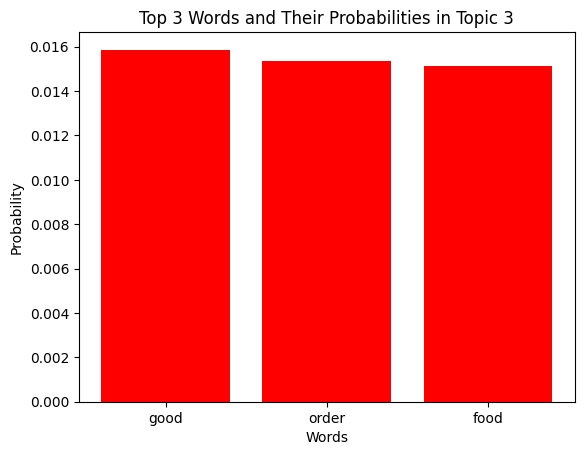

In [ ]:
# Cell for matplotlib visualization
# YOUR CODE HERE

# Extract words and probabilities
words, probabilities = zip(*top_words)

# Create a figure with subplots
fig, ax = plt.subplots()

# Plot the probabilities
ax.bar(words, probabilities, color='red')

# Add labels and title
ax.set_xlabel('Words')
ax.set_ylabel('Probability')
ax.set_title(f'Top 3 Words and Their Probabilities in Topic {topic_id + 1}')

# Rotate x-axis labels for better readability
# plt.xticks(rotation=45)

# Show plot
# plt.tight_layout()  # Adjust layout to prevent labels from getting cut off
plt.show()

# Assign visualization to a variable
visual_plot = fig